In [1]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster()
cluster.scale(8)

client = Client(cluster)
client

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:34659 Dashboard: http://127.0.0.1:56010/status,Cluster Workers: 8 Cores: 40 Memory: 169.33 GB


In [2]:
import numpy as np
import xarray as xr
# from dask.diagnostics import ProgressBar
import os.path as op
import xrft
import gsw
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid as xgrid
from xmitgcm import open_mdsdataset
from MITgcmutils import jmd95
from matplotlib.gridspec import GridSpec as GS
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'

In [4]:
grav = 9.807
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
ystart = 10
yend = 50
t_of_interest = 1
xchunk = 500

In [5]:
dsdiag = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run1963/ocn/' % 27), 
                        grid_dir = op.join(ddir,'grid_chaO/gridMIT_update1/'),
                        prefix = ['diag_Sbgt2D','diag_Sbgt3D'], delta_t = 2e2,
                        iters = range(788400,943920+2160,2160)
                        ).chunk({'XC':xchunk,'XG':xchunk}).isel(time=-1)
dsdiag

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option

<xarray.Dataset>
Dimensions:   (XC: 1000, XG: 1000, YC: 900, YG: 900, Z: 46, Zl: 46, Zp1: 47, Zu: 46)
Coordinates:
    iter      int64 dask.array<chunksize=(), meta=np.ndarray>
    time      float64 1.888e+08
  * XC        (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YC        (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * XG        (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * YG        (YG) >f4 -19.9583 -19.874968 -19.791634 ... 54.875034 54.95837
  * Z         (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * Zp1       (Zp1) >f4 0.0 -6.0935454 -12.814552 ... -5749.9097 -6000.3726
  * Zu        (Zu) >f4 -6.0935454 -12.814552 -19.91338 ... -5749.9097 -6000.3726
  * Zl        (Zl) >f4 0.0 -6.0935454 -12.814552 ... -5499.9937 -5749.9097
    rA        (YC, XC) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    dxG       (YG, XC) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    dyG       (YC, XG) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    Depth     (YC, XC) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    rAz       (YG, XG) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    dxC       (YC, XG) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    dyC       (YG, XC) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    rAw       (YC, XG) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    rAs       (YG, XC) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    drC       (Zp1) >f4 dask.array<chunksize=(47,), meta=np.ndarray>
    drF       (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefC    (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefF    (Zp1) >f4 dask.array<chunksize=(47,), meta=np.ndarray>
    hFacC     (Z, YC, XC) >f4 dask.array<chunksize=(46, 900, 500), meta=np.ndarray>
    hFacW     (Z, YC, XG) >f4 dask.array<chunksize=(46, 900, 500), meta=np.ndarray>
    hFacS     (Z, YG, XC) >f4 dask.array<chunksize=(46, 900, 500), meta=np.ndarray>
    maskC     (Z, YC, XC) bool dask.array<chunksize=(46, 900, 500), meta=np.ndarray>
    maskW     (Z, YC, XG) bool dask.array<chunksize=(46, 900, 500), meta=np.ndarray>
    maskS     (Z, YG, XC) bool dask.array<chunksize=(46, 900, 500), meta=np.ndarray>
    maskInC   (YC, XC) bool dask.array<chunksize=(900, 500), meta=np.ndarray>
    maskInW   (YC, XG) bool dask.array<chunksize=(900, 500), meta=np.ndarray>
    maskInS   (YG, XC) bool dask.array<chunksize=(900, 500), meta=np.ndarray>
Data variables:
    TOTSTEND  (Z, YC, XC) float32 dask.array<chunksize=(46, 900, 500), meta=np.ndarray>
    ADVr_SLT  (Zl, YC, XC) float32 dask.array<chunksize=(46, 900, 500), meta=np.ndarray>
    ADVx_SLT  (Z, YC, XG) float32 dask.array<chunksize=(46, 900, 500), meta=np.ndarray>
    ADVy_SLT  (Z, YG, XC) float32 dask.array<chunksize=(46, 900, 500), meta=np.ndarray>
    Diss_SLT  (Z, YC, XC) float32 dask.array<chunksize=(46, 900, 500), meta=np.ndarray>
    SFLUX     (YC, XC) float32 dask.array<chunksize=(900, 500), meta=np.ndarray>
    oceFWflx  (YC, XC) float32 dask.array<chunksize=(900, 500), meta=np.ndarray>
    WSLTMASS  (YC, XC) float32 dask.array<chunksize=(900, 500), meta=np.ndarray>

In [9]:
print(dsdiag.TOTSTEND.attrs, dsdiag.AdvD_SLT.attrs)

{'standard_name': 'TOTSTEND', 'long_name': 'Tendency of Salinity', 'units': 'psu/day'} {'standard_name': 'AdvD_SLT', 'long_name': 'Advective Flux Divergence of Salinity', 'units': 'psu.m^3/s', 'mate': 'ADVy_SLT'}


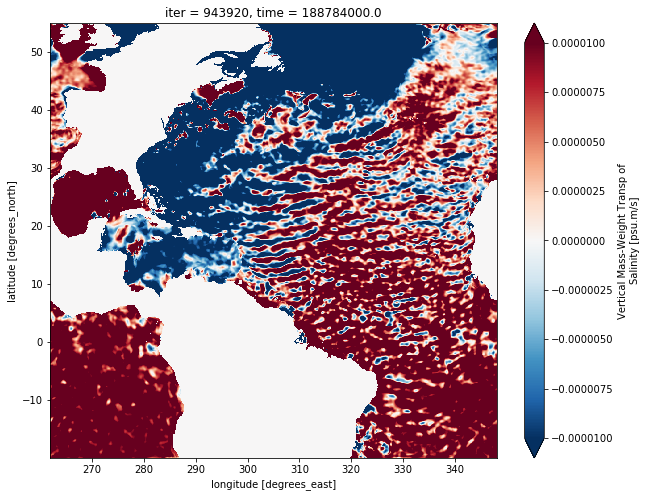

In [6]:
dsdiag.WSLTMASS.plot(vmax=1e-5, figsize=(10,8))

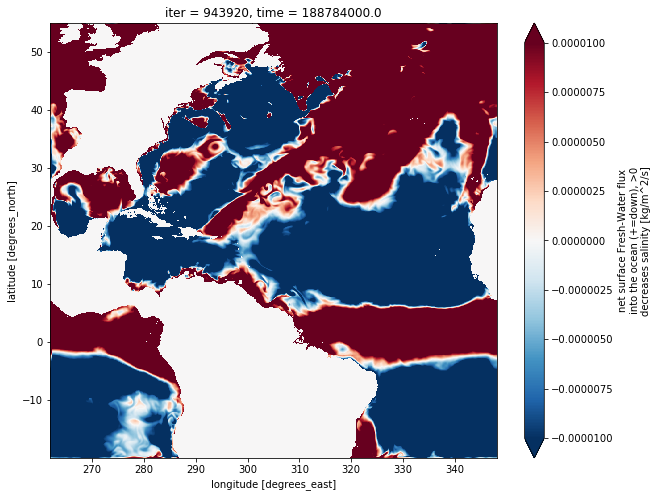

In [7]:
dsdiag.oceFWflx.plot(vmax=1e-5, figsize=(10,8))

In [9]:
grid = xgrid(dsdiag, periodic=['X'])
grid

<xgcm.Grid>
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center

In [10]:
Vol_r = dsdiag.rA**-1 * dsdiag.drF**-1 * dsdiag.hFacC**-1
Vol_r

<xarray.DataArray (YC: 900, XC: 1000, Z: 46)>
dask.array<mul, shape=(900, 1000, 46), dtype=float32, chunksize=(900, 500, 46), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    time     float64 1.888e+08
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
    rA       (YC, XC) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(900, 500), meta=np.ndarray>
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
    drF      (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefC   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    hFacC    (Z, YC, XC) >f4 dask.array<chunksize=(46, 900, 500), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(46, 900, 500), meta=np.ndarray>

In [12]:
Adv = - (-grid.diff(dsdiag.ADVr_SLT,'Z',boundary='fill') * Vol_r
         + grid.diff(dsdiag.ADVx_SLT,'X') * Vol_r
         + grid.diff(dsdiag.ADVy_SLT,'Y',boundary='fill') * Vol_r
        ).where(dsdiag.maskC!=0.)
# Adv = dsdiag.AdvD_SLT.where(dsdiag.maskC!=0.)
Adv

<xarray.DataArray (Z: 46, YC: 900, XC: 1000)>
dask.array<neg, shape=(46, 900, 1000), dtype=float32, chunksize=(45, 899, 499), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    time     float64 1.888e+08
    rA       (YC, XC) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(900, 500), meta=np.ndarray>
    drF      (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefC   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    hFacC    (Z, YC, XC) >f4 dask.array<chunksize=(46, 900, 500), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(46, 900, 500), meta=np.ndarray>

In [18]:
# DiffE = - (-grid.diff(dsdiag.DFrE_TH,'Z',boundary='fill') * Vol_r
#           + grid.diff(dsdiag.DFxE_TH,'X') * Vol_r
#           + grid.diff(dsdiag.DFyE_TH,'Y',boundary='fill') * Vol_r
#          ).where(dsdiag.maskC!=0.)
# DiffI = (grid.diff(dsdiag.DFrI_TH,'Z',boundary='fill') * Vol_r).where(dsdiag.maskC!=0.)
# DiffE

<xarray.DataArray (Z: 46, YC: 900, XC: 1000)>
dask.array<neg, shape=(46, 900, 1000), dtype=float32, chunksize=(45, 899, 499), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
    rA       (YC, XC) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    Depth    (YC, XC) >f4 3440.756 3215.3306 2099.5483 ... 2916.6108 2823.8076
    maskInC  (YC, XC) bool False False False False ... False False False False
    drF      (Z) >f4 6.0935454 6.721007 7.098827 ... 249.91599 250.46292
    PHrefC   (Z) >f4 29.88884 92.74422 160.5305 ... 55180.777 57635.133
    hFacC    (Z, YC, XC) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    maskC    (Z, YC, XC) bool True True True True ... False False False False
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    time  

In [19]:
# Kpp = grid.diff(dsdiag.KPPg_TH.where(dsdiag.maskInC!=0.),'Z',boundary='fill') * Vol_r
# Kpp

<xarray.DataArray (Z: 46, YC: 900, XC: 1000)>
dask.array<mul, shape=(46, 900, 1000), dtype=float32, chunksize=(45, 900, 500), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
    rA       (YC, XC) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    Depth    (YC, XC) >f4 3440.756 3215.3306 2099.5483 ... 2916.6108 2823.8076
    maskInC  (YC, XC) bool False False False False ... False False False False
    drF      (Z) >f4 6.0935454 6.721007 7.098827 ... 249.91599 250.46292
    PHrefC   (Z) >f4 29.88884 92.74422 160.5305 ... 55180.777 57635.133
    hFacC    (Z, YC, XC) >f4 dask.array<chunksize=(46, 900, 500), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(46, 900, 500), meta=np.ndarray>

In [39]:
swfrac = .62 * np.exp(dsdiag.Zl/.6) + (1-.62) * np.exp(dsdiag.Zl/20.)
swfrac1 = .62 * np.exp(dsdiag.Zl.shift(Zl=-1)/.6) + (1-.62) * np.exp(dsdiag.Zl.shift(Zl=-1)/20.)
rho0 = 9.998e2
Cp = 3.994e3
Ffw = (dsdiag.oceFWflx / (rho0*dsdiag.drF*dsdiag.hFacC) 
       * (swfrac - swfrac1).data
      ).where(dsdiag.maskC!=0.)
Sflx = (dsdiag.SFLUX / (rho0*dsdiag.drF[0]*dsdiag.hFacC.isel(Z=0))
       ).where(dsdiag.maskInC!=0.)
Sflx

<xarray.DataArray (YC: 900, XC: 1000)>
dask.array<where, shape=(900, 1000), dtype=float32, chunksize=(900, 500), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    time     float64 1.888e+08
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
    rA       (YC, XC) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(900, 500), meta=np.ndarray>
    Z        >f4 -3.0467727
    drF      float32 dask.array<chunksize=(), meta=np.ndarray>
    PHrefC   float32 dask.array<chunksize=(), meta=np.ndarray>
    hFacC    (YC, XC) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    maskC    (YC, XC) bool dask.array<chunksize=(900, 500), meta=np.ndarray>

In [33]:
ssurf_corr = 0.  # linFSConverveTr = F.
Surf_corr = (ssurf_corr - dsdiag.WSLTMASS.where(dsdiag.maskInC!=0.)
            ) / (dsdiag.drF[0]*dsdiag.hFacC.isel(Z=0))
Surf_corr

<xarray.DataArray (YC: 900, XC: 1000)>
dask.array<truediv, shape=(900, 1000), dtype=float32, chunksize=(900, 500), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    time     float64 1.888e+08
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
    rA       (YC, XC) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(900, 500), meta=np.ndarray>
    Z        >f4 -3.0467727
    drF      float32 dask.array<chunksize=(), meta=np.ndarray>
    PHrefC   float32 dask.array<chunksize=(), meta=np.ndarray>
    hFacC    (YC, XC) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    maskC    (YC, XC) bool dask.array<chunksize=(900, 500), meta=np.ndarray>

In [15]:
lhs = dsdiag.TOTSTEND.where(dsdiag.maskC!=0.).sel(YC=slice(-15,50+12**-1)).load()/86400
lhs.sel(XC=slice(268,268.3),YC=slice(35.75,36.1))[:] = np.nan
lhs_b = lhs.mean(['YC','XC']).compute()
lhs_b

<xarray.DataArray 'TOTSTEND' (Z: 46)>
array([ 4.18374849e-08,  1.32439130e-08,  1.53090140e-08,  1.74105251e-08,
        1.03866751e-08,  5.17568374e-09, -1.23769550e-08, -2.31304375e-08,
       -1.55924217e-08, -5.37046989e-09, -7.99686092e-09, -1.35407021e-08,
       -9.98405520e-09, -3.67260019e-09, -1.57843607e-09, -1.34677901e-09,
       -1.27262871e-09, -9.72345358e-10, -4.80787867e-10, -1.40171581e-11,
        2.16243513e-10,  7.16853471e-10,  9.82660110e-10,  9.01320128e-10,
        5.42809077e-10,  3.28414648e-10,  1.85349015e-10,  1.12608064e-10,
        7.12365030e-11,  5.14650164e-11,  4.30292171e-11,  3.49667893e-11,
        1.88701386e-11,  1.88155121e-11,  3.61072643e-11,  4.48555298e-11,
        4.56878024e-11,  2.82758822e-11,  1.22473495e-11,  7.45620579e-12,
       -1.02589441e-11, -7.26592185e-12,  8.92159389e-12,  1.88221954e-11,
        1.71743845e-11,  1.60441165e-11])
Coordinates:
    iter     int64 943920
    time     float64 1.888e+08
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
    drF      (Z) >f4 6.0935454 6.721007 7.098827 ... 249.91599 250.46292
    PHrefC   (Z) >f4 29.88884 92.74422 160.5305 ... 55180.777 57635.133

In [40]:
adv_b = Adv.sel(YC=slice(-15,50+12**-1)).load()
adv_b.sel(XC=slice(268,268.3),YC=slice(35.75,36.1))[:] = np.nan
adv_b = adv_b.mean(['YC','XC']).compute()
# diff_b = (DiffE+DiffI).sel(YC=slice(-15,50+12**-1)).mean(['YC','XC']).compute()
# diffE_b = DiffE.sel(YC=slice(-15,50+12**-1)).mean(['YC','XC']).compute()
# diffI_b = DiffI.sel(YC=slice(-15,50+12**-1)).mean(['YC','XC']).compute()
# kpp_b = Kpp.sel(YC=slice(-15,50+12**-1)).mean(['YC','XC']).compute()
dif_b = dsdiag.Diss_SLT.where(dsdiag.maskC!=0.).sel(YC=slice(-15,50+12**-1)).load()
dif_b.sel(XC=slice(268,268.3),YC=slice(35.75,36.1))[:] = np.nan
dif_b = dif_b.mean(['YC','XC']).compute()
# qsw_b = Qsw.sel(YC=slice(-15,50+12**-1)).mean(['YC','XC']).compute()
flx_b = (Sflx+Surf_corr).sel(YC=slice(-15,50+12**-1)).load()
flx_b.sel(XC=slice(268,268.3),YC=slice(35.75,36.1))[:] = np.nan
flx_b = flx_b.mean(['YC','XC']).compute()
totflx_b = np.zeros_like(dif_b)
totflx_b[0] += flx_b

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


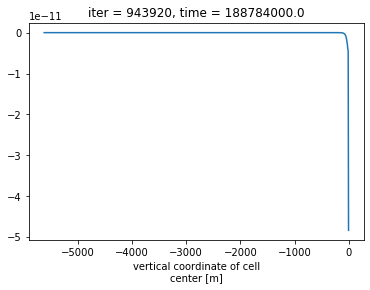

In [38]:
fw_b = Ffw.sel(YC=slice(-15,50+12**-1)).load()
fw_b.sel(XC=slice(268,268.3),YC=slice(35.75,36.1))[:] = np.nan
fw_b = fw_b.mean(['YC','XC']).compute()
fw_b.plot()

In [41]:
# rhs = (Adv+DiffE+DiffI+Kpp+Qsw).where(dsdiag.maskC!=0.).load()
rhs = (Adv+dsdiag.Diss_SLT.where(dsdiag.maskC!=0.)).where(dsdiag.maskC!=0.).load()
rhs.isel(Z=0)[:] += (Sflx+Surf_corr).load().data
rhs.sel(XC=slice(268,268.3),YC=slice(35.75,36.1))[:] = np.nan
rhs_b = rhs.sel(YC=slice(-15,50+12**-1)).mean(['YC','XC'])
rhs_b

<xarray.DataArray (Z: 46)>
array([ 4.18374952e-08,  1.32439206e-08,  1.53090234e-08,  1.74105299e-08,
        1.03866746e-08,  5.17567589e-09, -1.23769670e-08, -2.31304274e-08,
       -1.55924482e-08, -5.37046585e-09, -7.99688671e-09, -1.35406939e-08,
       -9.98406779e-09, -3.67260933e-09, -1.57842150e-09, -1.34678302e-09,
       -1.27263156e-09, -9.72344649e-10, -4.80784801e-10, -1.40150842e-11,
        2.16251489e-10,  7.16851578e-10,  9.82655068e-10,  9.01317743e-10,
        5.42802525e-10,  3.28411187e-10,  1.85346877e-10,  1.12610525e-10,
        7.12376963e-11,  5.14643120e-11,  4.30255484e-11,  3.49691769e-11,
        1.88712258e-11,  1.88115079e-11,  3.61033772e-11,  4.48608130e-11,
        4.56927898e-11,  2.82749674e-11,  1.22469014e-11,  7.45683550e-12,
       -1.02553434e-11, -7.26448589e-12,  8.91978331e-12,  1.88359519e-11,
        1.71547949e-11,  1.60116104e-11], dtype=float32)
Coordinates:
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
    iter     int64 943920
    time     float64 1.888e+08
    drF      (Z) >f4 6.0935454 6.721007 7.098827 ... 249.91599 250.46292
    PHrefC   (Z) >f4 29.88884 92.74422 160.5305 ... 55180.777 57635.133

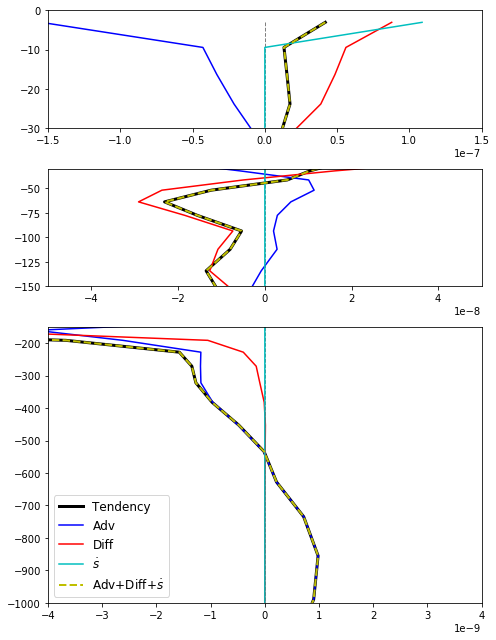

In [42]:
fig = plt.figure(figsize=(7,9))
fig.set_tight_layout(True)
gs = GS(4,1)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2:,0])

ax1.plot(np.zeros_like(dsdiag.Z), dsdiag.Z, ls='--', color='grey', lw=1)
ax2.plot(np.zeros_like(dsdiag.Z), dsdiag.Z, ls='--', color='grey', lw=1)
ax3.plot(np.zeros_like(dsdiag.Z), dsdiag.Z, ls='--', color='grey', lw=1)

ax1.plot(lhs_b, dsdiag.Z, 'k', lw=3)
ax1.plot(adv_b, dsdiag.Z, 'b')
ax1.plot(dif_b, dsdiag.Z, 'r')
# ax1.plot(diffE_b, dsdiag.Z, 'r--')
# ax1.plot(diffI_b, dsdiag.Z, 'r:')
# ax1.plot(kpp_b, dsdiag.Z, 'g')
ax1.plot(totflx_b, dsdiag.Z, 'c')
ax1.plot(rhs_b, dsdiag.Z, 'y--', lw=2)
ax1.set_xlim([-1.5e-7,1.5e-7])
ax1.set_ylim([-3e1,0])

ax2.plot(lhs_b, dsdiag.Z, 'k', lw=3)
ax2.plot(adv_b, dsdiag.Z, 'b')
ax2.plot(dif_b, dsdiag.Z, 'r')
# ax2.plot(diffE_b, dsdiag.Z, 'r--')
# ax2.plot(diffI_b, dsdiag.Z, 'r:')
# ax2.plot(kpp_b, dsdiag.Z, 'g')
ax2.plot(totflx_b, dsdiag.Z, 'c')
ax2.plot(rhs_b, dsdiag.Z, 'y--', lw=2)
ax2.set_xlim([-5e-8,5e-8])
ax2.set_ylim([-1.5e2,-3e1])

ax3.plot(lhs_b, dsdiag.Z, 'k', lw=3, label='Tendency')
ax3.plot(adv_b, dsdiag.Z, 'b', label='Adv')
ax3.plot(dif_b, dsdiag.Z, 'r', label='Diff')
# ax3.plot(diffE_b, dsdiag.Z, 'r--')
# ax3.plot(diffI_b, dsdiag.Z, 'r:')
# ax3.plot(kpp_b, dsdiag.Z, 'g', label='KPP')
ax3.plot(totflx_b, dsdiag.Z, 'c', label=r'$\dot{s}$')
ax3.plot(rhs_b, dsdiag.Z, 'y--', lw=2, label=r'Adv+Diff+$\dot{s}$')
ax3.set_xlim([-4e-9,4e-9])
ax3.set_ylim([-1e3,-1.5e2])
ax3.legend(loc='lower left', fontsize=12)

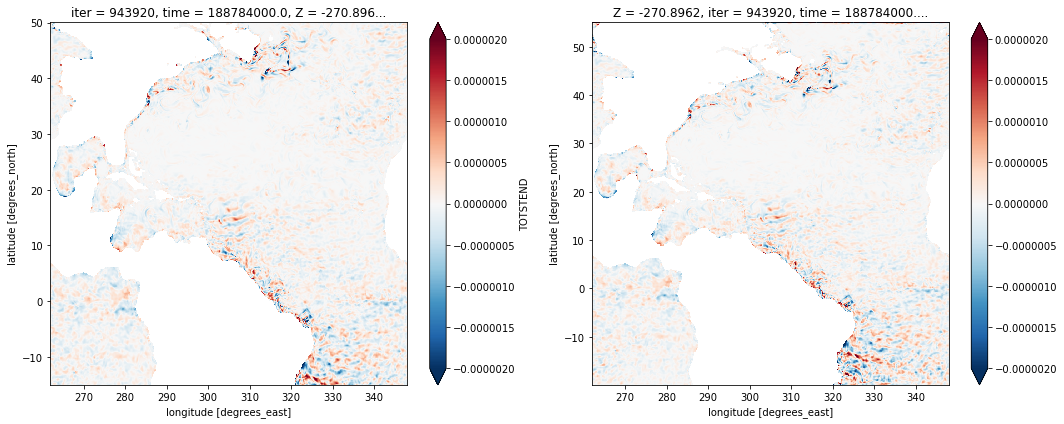

In [46]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.set_tight_layout(True)
lhs[15].plot(ax=ax1, vmax=2e-6)
rhs.where(dsdiag.maskC!=0.)[15].plot(ax=ax2, vmax=2e-6)

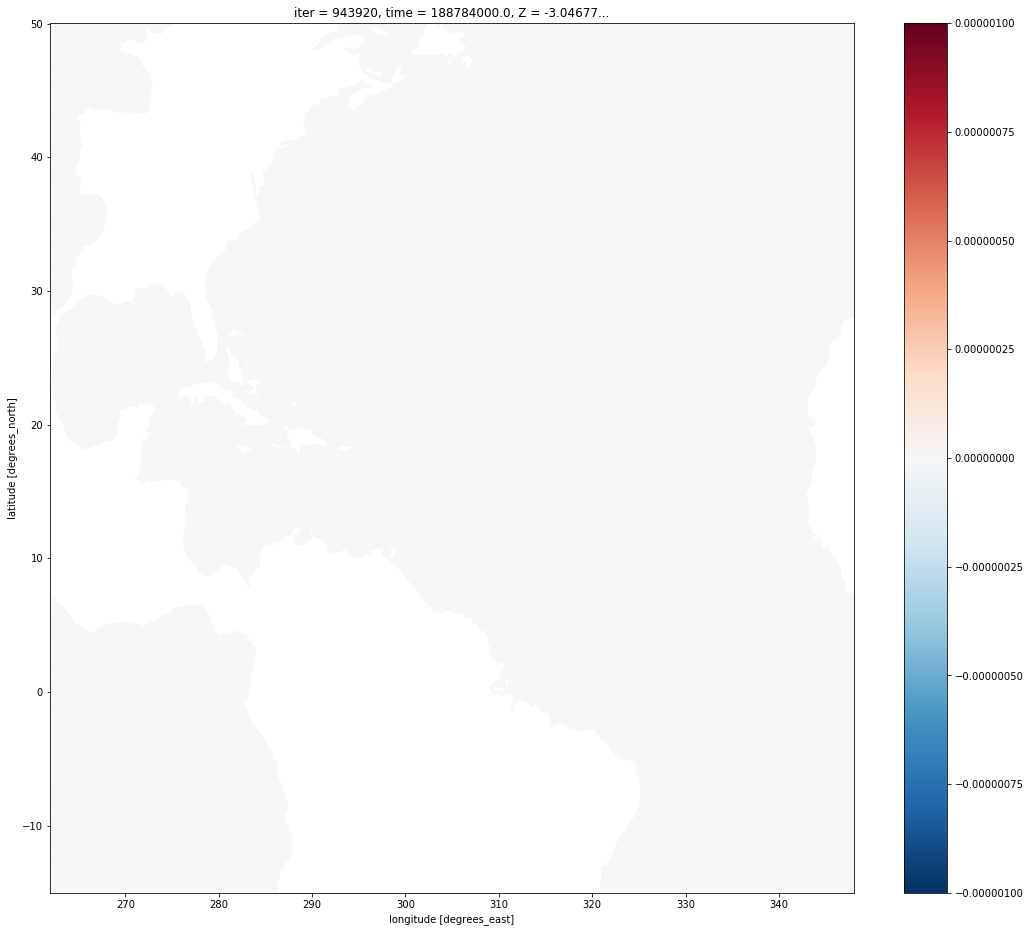

In [47]:
(lhs-rhs)[0].plot(figsize=(18,16), vmax=1e-6)